In [4]:
# Вариант 22

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from collections import Counter

In [5]:
data = pd.read_excel('.\data2.xlsx',header = None)

data.head

<bound method NDFrame.head of       0     1     2     3     4     5     6     7     8     9     10    11  \
0   0.38  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.35  0.27  0.00  0.00   
1   0.00  0.24  0.00  0.64  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.12   
2   0.00  0.00  0.24  0.00  0.12  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
3   0.00  0.20  0.00  0.22  0.00  0.00  0.00  0.00  0.00  0.00  0.27  0.31   
4   0.00  0.00  0.00  0.00  0.12  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
5   0.00  0.00  0.00  0.00  0.00  0.17  0.22  0.22  0.18  0.00  0.00  0.00   
6   0.00  0.00  0.00  0.00  0.00  0.21  0.28  0.32  0.00  0.00  0.00  0.00   
7   0.00  0.00  0.00  0.00  0.00  0.28  0.19  0.17  0.00  0.00  0.00  0.15   
8   0.64  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.24  0.12  0.00  0.00   
9   0.40  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.36  0.24  0.00  0.00   
10  0.00  0.24  0.00  0.64  0.00  0.00  0.00  0.00  0.00  0.00  0.12  0.00   
11  0.00  0.24  0.00  0.52  0.00  

1. Нарисовать граф цепи

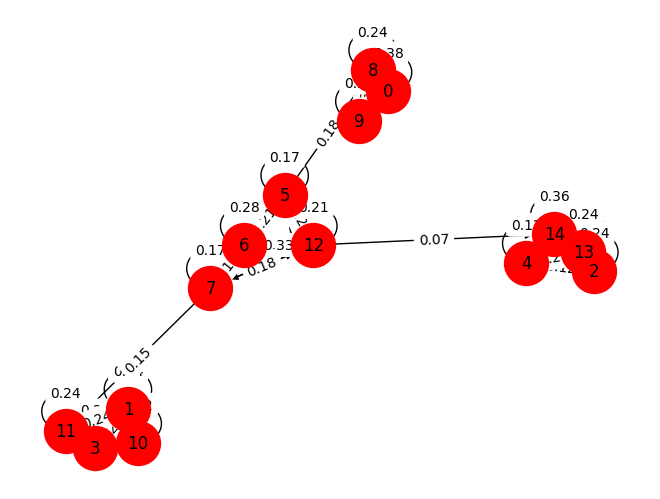

In [6]:
def draw_graph(matrix):
    G = nx.DiGraph()
    states = matrix.shape[0]
    for i in range(states):
        for j in range(states):
            if matrix[i, j] > 0:
                G.add_edge(i, j, weight=matrix[i, j])

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color='red')
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): f'{weight:.2f}' for (i, j), weight in edge_labels.items()})
    plt.show()

draw_graph(data.values)

Перерисуем граф вручную с указанием направления стрелок.
![alt text](цепь-1.jpg)

Из рисунка видим, что состояния 5,6,7,12 являются несущественными т.к. при большом числе переходов система выйдет из этих состояний и никогда к ним больше не вернется

2. Проверить выполнение критерия эргодичности

In [7]:
def ergodic_check(matrix):
    states = matrix.shape[0]
    reachable = np.zeros((states, states), dtype=bool)

    for k in range(states):
        for i in range(states):
            for j in range(states):
                reachable[i, j] = reachable[i, j] or (matrix[i, k] and matrix[k, j])

    return np.all(reachable)

ergodic_check(data.values)

np.False_

3. Рассчитать предельные вероятности

In [8]:
def stationary_distribution(transition_matrix):
    # Приводим к форме numpy array
    P = np.array(transition_matrix)
    
    # Находим размерность матрицы P
    num_states = P.shape[0]
    
    # Создаем матрицу A для решения (A @ π = 0)
    A = np.vstack((P.T - np.eye(num_states), np.ones(num_states)))
    
    # Вектор для нахождения предельного распределения
    b = np.zeros(num_states + 1)
    b[-1] = 1  # Сумма вероятностей равна 1
    
    # Решаем систему линейных уравнений
    pi = np.linalg.lstsq(A, b, rcond=None)[0]
    
    return pi

stationary_distribution(data.values)

array([ 1.34360141e-01,  7.81877704e-02,  3.66371693e-02,  1.51965207e-01,
        7.81803706e-02,  0.00000000e+00, -5.55111512e-17, -6.93889390e-17,
        9.13166225e-02,  6.21516219e-02,  4.66256884e-02,  7.43312454e-02,
        8.32667268e-17,  1.32591660e-01,  1.13652504e-01])

Для получения предельного распределения для каждого начального состояния мы могли бы записать разные векторы начальных состояний и поочередно домножить их на матрицу переходов, но нам нужно высчитать вероятность без операций над матрицей переходов.

Для этого упростим исходную цепь, выделим из нее группы состояний из которых невозможно попасть в другие состояния и составим для каждой из них собственную матрицу переходов

Группа 1 - состояния 1,3,10,11
Группа 2 - состояния 2,4,13,14
Группа 3 - состояния 0,8,9



Группа 1

In [9]:
data_group1 = pd.read_excel('.\data_1_3_10_11.xlsx',header = None)

data_group1.head

<bound method NDFrame.head of       0     1     2     3
0  0.24  0.64  0.00  0.12
1  0.20  0.22  0.27  0.31
2  0.24  0.64  0.12  0.00
3  0.24  0.52  0.00  0.24>

Проверяем эргодичность

In [10]:
ergodic_check(data_group1.values)

np.True_

Матрица эргодическая, а значит вне зависимости от начального состояния сходится к предельным вероятностям. Т.е. предельные вероятности одинаковые для все состояний - 1,3,10,11. Проверим это воздведя матрицу переходов в степень 1000

In [11]:

probability_matrix_group1 = np.linalg.matrix_power(data_group1.values, 10000)
print(probability_matrix_group1)
print(stationary_distribution(data_group1.values))

[[0.22268745 0.43281378 0.13279514 0.21170364]
 [0.22268745 0.43281378 0.13279514 0.21170364]
 [0.22268745 0.43281378 0.13279514 0.21170364]
 [0.22268745 0.43281378 0.13279514 0.21170364]]
[0.22268745 0.43281378 0.13279514 0.21170364]


Выполним аналогичные проверки и вычисления для групп 2 и 3

In [12]:
data_group2 = pd.read_excel('.\data_2_4_13_14.xlsx',header = None)
probability_matrix_group2 = stationary_distribution(data_group2.values)
print(ergodic_check(data_group2.values))
print (stationary_distribution(data_group2.values))

data_group3 = pd.read_excel('.\data_0_8_9.xlsx',header = None)
probability_matrix_group3 = stationary_distribution(data_group3.values)
print(ergodic_check(data_group3.values))
print (stationary_distribution(data_group3.values))

True
[0.10147066 0.21652911 0.36722715 0.31477308]
True
[0.46680643 0.31726066 0.21593291]


С группой несущественных состояний сложнее, но предельные вероятности будут сходится к переходам к связанным состояниям групп существуенных состояний - 11,8,14. Посчитаем распределенения по этим состояниям. Оставляем в исходной матрице переходов только строки несущественных состояний - 5,6,7,12 и строки состояний к которым возможен переход 8,11,14.

Для строк состояний 8,11,14 укажем единственную вероятность равную 100% - сохранение текущего состояния

In [13]:
data_group4 = pd.read_excel('.\data_5_6_7_12.xlsx',header = None)
print(ergodic_check(data_group4.values))
print (stationary_distribution(data_group4.values))

False
[-1.49698560e-16 -3.88578059e-16 -2.77555756e-16  3.33333333e-01
  3.33333333e-01 -1.24900090e-16  3.33333333e-01]


Получается, что из группы состояний 4 мы можем перейти в каждую группу изолированных состояний с равной вероятностью

Чтобы посмотреть зависимости вероятности от исходного состояния возведем матрицу переходов в степень 10000

In [14]:
probability_matrix_group4 = np.linalg.matrix_power(data_group4.values, 10000)
probability_matrix_group4

array([[0.        , 0.        , 0.        , 0.54337748, 0.32065884,
        0.        , 0.13596368],
       [0.        , 0.        , 0.        , 0.44232512, 0.39719907,
        0.        , 0.1604758 ],
       [0.        , 0.        , 0.        , 0.39036118, 0.4704908 ,
        0.        , 0.13914801],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.41815389, 0.35835746,
        0.        , 0.22348865],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        ]])

In [15]:
probability_matrix_new = probability_matrix_group4[[0,1,2,5],:]
probability_matrix_new = probability_matrix_new[:,[3,4,6]]
probability_matrix_new

array([[0.54337748, 0.32065884, 0.13596368],
       [0.44232512, 0.39719907, 0.1604758 ],
       [0.39036118, 0.4704908 , 0.13914801],
       [0.41815389, 0.35835746, 0.22348865]])

Домножив вероятности переходов в изолированные группы на предельные распределения в ней получим переходов, которая учитывает не только связанное состояния изолированной группы, но все ее состояния. Для этого выкинем из матрицы переходов все лишние значения оставив по вертикали только искомые состояния 5,6,7,8, а по горизонтали соотвественно 8,11,14 

In [16]:
total_matrix = [[0 for _ in range(15)] for _ in range(probability_matrix_new.shape[0])]

total_matrix

for i in range(probability_matrix_new.shape[0]):
    # Для группы 1
    total_matrix[i][1] = round(probability_matrix_new[i,1] * probability_matrix_group1[0,0],3)
    total_matrix[i][3] = round(probability_matrix_new[i,1] * probability_matrix_group1[0,1],3)
    total_matrix[i][10] = round(probability_matrix_new[i,1] * probability_matrix_group1[0,2],3)
    total_matrix[i][11] = round(probability_matrix_new[i,1] * probability_matrix_group1[0,3],3)
    # Для группы 2
    total_matrix[i][2] = round(probability_matrix_new[i,2] * probability_matrix_group2[0],3)
    total_matrix[i][4] = round(probability_matrix_new[i,2] * probability_matrix_group2[1],3)
    total_matrix[i][13] = round(probability_matrix_new[i,2] * probability_matrix_group2[2],3)
    total_matrix[i][14] = round(probability_matrix_new[i,2] * probability_matrix_group2[3],3)
    # Для группы 3
    total_matrix[i][0] = round(probability_matrix_new[i,0] * probability_matrix_group3[0],3)
    total_matrix[i][8] = round(probability_matrix_new[i,0] * probability_matrix_group3[1],3)
    total_matrix[i][9] = round(probability_matrix_new[i,0] * probability_matrix_group3[2],3)

for row in total_matrix:
    print(" | ".join(f"{value:.2f}" for value in row))


0.25 | 0.07 | 0.01 | 0.14 | 0.03 | 0.00 | 0.00 | 0.00 | 0.17 | 0.12 | 0.04 | 0.07 | 0.00 | 0.05 | 0.04
0.21 | 0.09 | 0.02 | 0.17 | 0.04 | 0.00 | 0.00 | 0.00 | 0.14 | 0.10 | 0.05 | 0.08 | 0.00 | 0.06 | 0.05
0.18 | 0.10 | 0.01 | 0.20 | 0.03 | 0.00 | 0.00 | 0.00 | 0.12 | 0.08 | 0.06 | 0.10 | 0.00 | 0.05 | 0.04
0.20 | 0.08 | 0.02 | 0.15 | 0.05 | 0.00 | 0.00 | 0.00 | 0.13 | 0.09 | 0.05 | 0.08 | 0.00 | 0.08 | 0.07


Выполним проверку. Суммы по строкам в итоговой матрице должны быть равны единице

In [17]:
print(sum(total_matrix[0]))
print(sum(total_matrix[1]))
print(sum(total_matrix[2]))
print(sum(total_matrix[3]))

1.0
1.0
1.0
1.0


Если распределение между несущественными состояние равномерное - можем получить итоговые вероятности как среднее от значений вероятностей всех состояний. Также выполним проверку.

In [18]:
#equal_matrix = [np.mean(total_matrix[:,i]) for i in range(14)]

#equal_matrix

total_matrix2 = np.array(total_matrix)
equal_matrix = [np.mean(total_matrix2[:,i]) for i in range(15)]

for value in equal_matrix:
    print(round(value,2))

sum(equal_matrix)


0.21
0.09
0.02
0.17
0.04
0.0
0.0
0.0
0.14
0.1
0.05
0.08
0.0
0.06
0.05


np.float64(1.0)

4. Имитационное моделирование

* перебираем все состояния в качестве исходных;
* случайно разыграть переход в новое состояние, учитывая распределение вероятностей перехода;
* совершить 100 переходов;
* подсчитать число вхождений в каждое из состояний системы;
* повторить эксперимент 10 раз для каждого исходного состояния;


In [19]:
data.values

array([[0.38, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.35, 0.27, 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.24, 0.  , 0.64, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.12, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.24, 0.  , 0.12, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.4 , 0.24],
       [0.  , 0.2 , 0.  , 0.22, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.27,
        0.31, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.52, 0.36],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.22, 0.22, 0.18, 0.  , 0.  ,
        0.  , 0.21, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.28, 0.32, 0.  , 0.  , 0.  ,
        0.  , 0.19, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.28, 0.19, 0.17, 0.  , 0.  , 0.  ,
        0.15, 0.21, 0.  , 0.  ],
       [0.64, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.24, 0.12, 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.4 , 0.  , 0.  , 0.  , 0.  ,

In [20]:
steps = 100

def simulate_chain(matrix, check_state,steps,tries):

    states_visited = []
    
    for _ in range(tries):
        num_states = matrix.shape[0]
        state = check_state

        for _ in range(steps):
            state = np.random.choice(num_states, p=matrix[state])
            states_visited.append(state)

    return states_visited




simulation_test = simulate_chain(data.values,6,steps,10) 

Counter(simulation_test)



Counter({0: 203,
         8: 162,
         3: 146,
         9: 98,
         11: 88,
         1: 72,
         13: 40,
         10: 38,
         6: 35,
         7: 27,
         5: 23,
         14: 21,
         12: 18,
         4: 16,
         2: 13})

Видим что среди подсчитанных значений есть состояния из разных изолированных групп, значит алгоритм подсчета работает правильно

In [21]:
group1 = [1,3,10,11]
group2 = [2,4,13,14]
group3 = [0,8,9]
group4 = [5,6,7,12]


def simulation_test_classifier(matrix, check_state,steps,tries):
    simulation_test = simulate_chain(matrix, check_state,steps,tries) 
    for i in range(len(simulation_test)):
       if simulation_test[i] in group1:
           simulation_test[i] = (100+simulation_test[i])/100
       elif simulation_test[i] in group2:
           simulation_test[i] = (200+simulation_test[i])/100
       elif simulation_test[i] in group3:
           simulation_test[i] = (300+simulation_test[i])/100
       else:
           simulation_test[i] = (400+simulation_test[i])/100
    return simulation_test

simulation_test = simulation_test_classifier(data.values,6,steps,10) 
simulation_test


[4.07,
 4.12,
 4.05,
 4.12,
 4.07,
 4.12,
 4.12,
 4.05,
 3.08,
 3.08,
 3.08,
 3.0,
 3.0,
 3.09,
 3.0,
 3.09,
 3.09,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.09,
 3.09,
 3.09,
 3.0,
 3.09,
 3.0,
 3.08,
 3.0,
 3.09,
 3.0,
 3.0,
 3.09,
 3.09,
 3.08,
 3.0,
 3.08,
 3.0,
 3.08,
 3.0,
 3.08,
 3.0,
 3.0,
 3.09,
 3.08,
 3.0,
 3.0,
 3.09,
 3.08,
 3.0,
 3.0,
 3.09,
 3.0,
 3.0,
 3.08,
 3.0,
 3.09,
 3.08,
 3.08,
 3.0,
 3.08,
 3.08,
 3.09,
 3.09,
 3.08,
 3.08,
 3.08,
 3.0,
 3.08,
 3.0,
 3.08,
 3.0,
 3.0,
 3.09,
 3.0,
 3.08,
 3.0,
 3.0,
 3.08,
 3.0,
 3.08,
 3.0,
 3.09,
 3.08,
 3.09,
 3.08,
 3.0,
 3.08,
 3.0,
 3.08,
 3.09,
 3.09,
 3.0,
 3.09,
 3.0,
 3.08,
 3.0,
 3.09,
 3.08,
 4.06,
 4.07,
 4.06,
 4.07,
 4.07,
 1.11,
 1.03,
 1.03,
 1.1,
 1.03,
 1.1,
 1.1,
 1.01,
 1.03,
 1.01,
 1.03,
 1.01,
 1.01,
 1.03,
 1.11,
 1.03,
 1.11,
 1.03,
 1.03,
 1.01,
 1.11,
 1.11,
 1.03,
 1.11,
 1.11,
 1.03,
 1.1,
 1.03,
 1.03,
 1.11,
 1.01,
 1.11,
 1.01,
 1.03,
 1.03,
 1.11,
 1.11,
 1.03,
 1.1,
 1.1,
 1.03,
 1.1,
 1.01,
 1.03,
 1.1

* построить «графики» переключений состояний цепи (для наглядности соединяем дискретные точки) для 3 произвольных экспериментов;

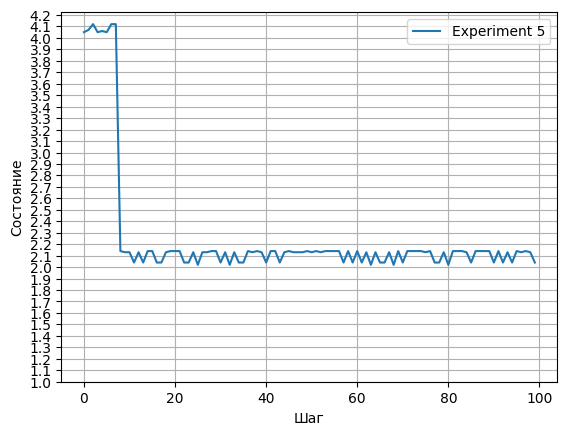

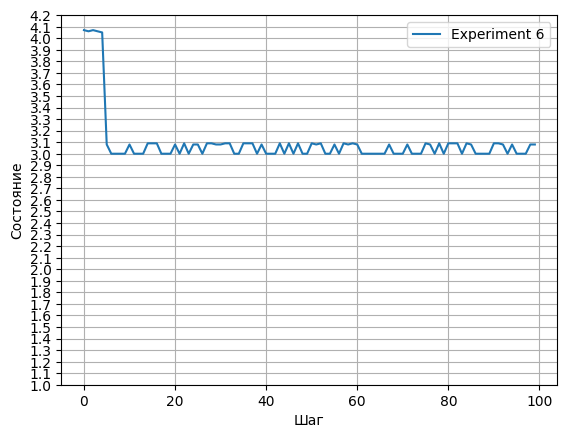

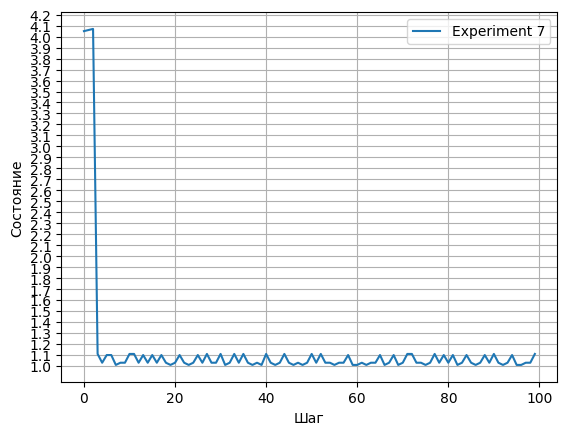

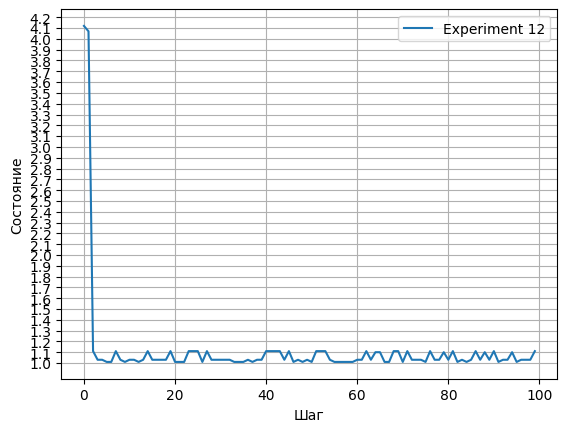

In [22]:
steps = 100
tries = 10

experiments = [simulation_test_classifier(data.values,state, steps,tries) for state in range(15)]
experiments

for i in (5,6,7,12):
    plt.plot(experiments[i][0:100], label=f'Experiment {i}')
    plt.xlabel('Шаг')
    plt.ylabel('Состояние')
    plt.legend()
    plt.yticks(np.arange(1, 4.3, 0.1))
    plt.grid()
    plt.show()

In [23]:
num_states = data.shape[0]
# Двухмерный массив размером 15x15 для подсчета статистики
state_counts = np.zeros((num_states, num_states), dtype=int)

experiments_unmarked = [simulate_chain(data.values,state, steps,tries) for state in range(15)]

for i in range(15):
    for j in range(steps*tries):
        k = experiments_unmarked[i][j]
        state_counts[i][k] += 1

relative_frequencies = state_counts/(steps*tries)

print ("Значения полученные путем моделирования:\n")
for row in relative_frequencies:
    print(" | ".join(f"{value:.2f}" for value in row))

Значения полученные путем моделирования:

0.45 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.34 | 0.21 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
0.00 | 0.21 | 0.00 | 0.43 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.14 | 0.21 | 0.00 | 0.00 | 0.00
0.00 | 0.00 | 0.09 | 0.00 | 0.22 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.37 | 0.32
0.00 | 0.22 | 0.00 | 0.44 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.13 | 0.21 | 0.00 | 0.00 | 0.00
0.00 | 0.00 | 0.10 | 0.00 | 0.22 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.36 | 0.32
0.17 | 0.10 | 0.01 | 0.17 | 0.01 | 0.04 | 0.05 | 0.05 | 0.13 | 0.07 | 0.06 | 0.08 | 0.03 | 0.02 | 0.02
0.18 | 0.07 | 0.02 | 0.15 | 0.04 | 0.03 | 0.03 | 0.03 | 0.12 | 0.07 | 0.04 | 0.09 | 0.02 | 0.07 | 0.06
0.12 | 0.13 | 0.00 | 0.22 | 0.02 | 0.03 | 0.02 | 0.02 | 0.10 | 0.07 | 0.07 | 0.12 | 0.02 | 0.03 | 0.03
0.47 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.31 | 0.22 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
0.45 | 0.00 | 0.00 | 0.00 | 0.0

In [24]:
truth_distribution = np.linalg.matrix_power(data.values, 10000)

print ("Значения полученные аналитическим путем:\n")
for row in truth_distribution:
    print(" | ".join(f"{value:.2f}" for value in row))


Значения полученные аналитическим путем:

0.47 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.32 | 0.22 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
0.00 | 0.22 | 0.00 | 0.43 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.13 | 0.21 | 0.00 | 0.00 | 0.00
0.00 | 0.00 | 0.10 | 0.00 | 0.22 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.37 | 0.31
0.00 | 0.22 | 0.00 | 0.43 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.13 | 0.21 | 0.00 | 0.00 | 0.00
0.00 | 0.00 | 0.10 | 0.00 | 0.22 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.37 | 0.31
0.25 | 0.07 | 0.01 | 0.14 | 0.03 | 0.00 | 0.00 | 0.00 | 0.17 | 0.12 | 0.04 | 0.07 | 0.00 | 0.05 | 0.04
0.21 | 0.09 | 0.02 | 0.17 | 0.03 | 0.00 | 0.00 | 0.00 | 0.14 | 0.10 | 0.05 | 0.08 | 0.00 | 0.06 | 0.05
0.18 | 0.10 | 0.01 | 0.20 | 0.03 | 0.00 | 0.00 | 0.00 | 0.12 | 0.08 | 0.06 | 0.10 | 0.00 | 0.05 | 0.04
0.47 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.32 | 0.22 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
0.47 | 0.00 | 0.00 | 0.00 | 0.0

In [25]:
#Разница значений

delta = truth_distribution - relative_frequencies

print ("Разница значений:\n")
for row in delta:
    print(" | ".join(f"{value:.2f}" for value in row))

Разница значений:

0.01 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | -0.02 | 0.01 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
0.00 | 0.01 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | -0.01 | 0.00 | 0.00 | 0.00 | 0.00
0.00 | 0.00 | 0.01 | 0.00 | -0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | -0.00 | -0.01
0.00 | 0.00 | 0.00 | -0.01 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.01 | 0.00 | 0.00 | 0.00 | 0.00
0.00 | 0.00 | -0.00 | 0.00 | -0.01 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.01 | -0.00
0.09 | -0.03 | 0.00 | -0.03 | 0.02 | -0.04 | -0.05 | -0.05 | 0.04 | 0.05 | -0.02 | -0.01 | -0.03 | 0.03 | 0.03
0.03 | 0.02 | -0.00 | 0.02 | -0.01 | -0.03 | -0.03 | -0.03 | 0.02 | 0.03 | 0.02 | -0.01 | -0.02 | -0.01 | -0.01
0.06 | -0.03 | 0.01 | -0.02 | 0.01 | -0.03 | -0.02 | -0.02 | 0.03 | 0.02 | -0.00 | -0.02 | -0.02 | 0.02 | 0.01
-0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.01 | -0.01 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
0.01 | 0.00 | 0.00